In [ ]:
!pip install SimpleITK # Procesamiento de imagenes medicas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 41.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import numpy as np
import SimpleITK as sitk
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Activation, BatchNormalization, SpatialDropout3D,
                                    Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, concatenate)
import cv2
from skimage.transform import resize
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ARQUITECTURA ORIGINAL
bnorm_axis = -1
nfilters = np.array([32, 48, 96, 192, 384])
drop_rate = 0.2
input_shape = (192, 192, 192, 1)

def unet_3d_version10(input_shape):
    inputs = Input(shape=input_shape)

    # ============== Encoder ==============
    # Encoder Block 0
    e0 = Conv3D(filters=nfilters[0], kernel_size=(3,3,3), padding='same')(inputs)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv3D(filters=nfilters[0], kernel_size=(3,3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    # Encoder Block 1
    e1 = MaxPooling3D((2,2,2))(e0)
    e1 = Conv3D(nfilters[1], (3,3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv3D(nfilters[1], (3,3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    # Encoder Block 2
    e2 = SpatialDropout3D(drop_rate)(e1, training=True)
    e2 = MaxPooling3D((2,2,2))(e2)
    e2 = Conv3D(nfilters[2], (3,3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv3D(nfilters[2], (3,3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    # Encoder Block 3
    e3 = SpatialDropout3D(drop_rate)(e2, training=True)
    e3 = MaxPooling3D((2,2,2))(e3)
    e3 = Conv3D(nfilters[3], (3,3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv3D(nfilters[3], (3,3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    # ============== Bottleneck ==============
    e4 = SpatialDropout3D(drop_rate)(e3, training=True)
    e4 = MaxPooling3D((2,2,2))(e4)
    e4 = Conv3D(nfilters[4], (3,3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv3D(nfilters[4], (3,3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)

    # ============== Decoder ==============
    # Decoder Block 3
    d3 = SpatialDropout3D(drop_rate)(e4, training=True)
    d3 = UpSampling3D((2,2,2))(d3)
    d3 = concatenate([e3, d3])
    d3 = Conv3DTranspose(nfilters[3], (3,3,3), padding='same')(d3)
    d3 = BatchNormalization(axis=bnorm_axis)(d3)
    d3 = Activation('relu')(d3)
    d3 = Conv3DTranspose(nfilters[3], (3,3,3), padding='same')(d3)
    d3 = BatchNormalization(axis=bnorm_axis)(d3)
    d3 = Activation('relu')(d3)

    # Decoder Block 2
    d2 = SpatialDropout3D(drop_rate)(d3, training=True)
    d2 = UpSampling3D((2,2,2))(d2)
    d2 = concatenate([e2, d2])
    d2 = Conv3DTranspose(nfilters[2], (3,3,3), padding='same')(d2)
    d2 = BatchNormalization(axis=bnorm_axis)(d2)
    d2 = Activation('relu')(d2)
    d2 = Conv3DTranspose(nfilters[2], (3,3,3), padding='same')(d2)
    d2 = BatchNormalization(axis=bnorm_axis)(d2)
    d2 = Activation('relu')(d2)

    # Decoder Block 1
    d1 = UpSampling3D((2,2,2))(d2)
    d1 = concatenate([e1, d1])
    d1 = Conv3DTranspose(nfilters[1], (3,3,3), padding='same')(d1)
    d1 = BatchNormalization(axis=bnorm_axis)(d1)
    d1 = Activation('relu')(d1)
    d1 = Conv3DTranspose(nfilters[1], (3,3,3), padding='same')(d1)
    d1 = BatchNormalization(axis=bnorm_axis)(d1)
    d1 = Activation('relu')(d1)

    # Decoder Block 0
    d0 = UpSampling3D((2,2,2))(d1)
    d0 = concatenate([e0, d0])
    d0 = Conv3DTranspose(nfilters[0], (3,3,3), padding='same')(d0)
    d0 = BatchNormalization(axis=bnorm_axis)(d0)
    d0 = Activation('relu')(d0)
    d0 = Conv3DTranspose(nfilters[0], (3,3,3), padding='same')(d0)
    d0 = BatchNormalization(axis=bnorm_axis)(d0)
    d0 = Activation('relu')(d0)

    # Capa de salida
    outputs = Conv3D(1, (1,1,1), activation='sigmoid', padding='same')(d0)

    # Compilación
    # Usamos combined_loss (dice_loss + focal_loss) y las métricas definidas en la sección anterior
    optimizer = tf.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss=combined_loss, metrics=[dice_metric, jaccard_metric, precision_metric, recall_metric])

    model.summary()
    return model

In [ ]:
# CARGA DEL MODELO, ELECCION DE LA CAPA Y CREACIÓN MONTAJE DE GRAD_CAM
MODEL_PATH = # Ruta a tu modelo
IMG_PATH = # Ruta a tu imagen
CLASS_INDEX = 1  # Clase a visualizar (1 para lesión)
INPUT_SHAPE = (192, 192, 192, 1)  # Tamaño original del modelo
GRAD_CAM_INPUT_SHAPE = (96, 96, 96, 1)  # Tamaño de entrada para Grad-CAM

# 1. Cargamos el modelo COMPLETO
Model_3D = unet_3d_version10(INPUT_SHAPE)
Model_3D.load_weights(MODEL_PATH)
print(f'Modelo cargado desde {MODEL_PATH}')
Model_3D.summary()

Modelo cargado desde /content/drive/MyDrive/best_model_fold_3.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 192,  │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 192, 192, 192,  │            896 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 192, 192,  │            128 │ conv3d[0][0]           │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 192, 192,  │              0 │ batch_normalization[0… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 192, 192, 192,  │         27,680 │ activation[0][0]       │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 192, 192,  │            128 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 192, 192,  │              0 │ batch_normalization_1… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 96, 96, 96, 32) │              0 │ activation_1[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 96, 96, 96, 48) │         41,520 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 96, 96, 48) │            192 │ conv3d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 96, 96, 48) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 96, 96, 96, 48) │         62,256 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 96, 96, 48) │            192 │ conv3d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 96, 96, 96, 48) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout3d    

 Total params: 13,303,873 (50.75 MB)

 Trainable params: 13,299,393 (50.73 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [ ]:
# 2. Elegimos el nombre de la capa donde se aplica Grad-CAM
LAYER_NAME = 'conv3d_4' # Debe asignarse segun la el nombre asignado del summary del modelo.

In [ ]:
# 3. Creamos el modelo Grad-CAM
grad_model = unet_3d_version10(GRAD_CAM_INPUT_SHAPE)

In [ ]:
# 4. Copiamos los pesos
layer_index = -1
for i, layer in enumerate(Model_3D.layers):
    if layer.name == LAYER_NAME:
        layer_index = i
        break
if layer_index == -1:
    raise ValueError(f"Capa {LAYER_NAME} no encontrada en Model_3D")

for i in range(layer_index):
    grad_model.layers[i].set_weights(Model_3D.layers[i].get_weights())

In [ ]:
# 5. Define el grad_model final
output_grad_model = grad_model.layers[layer_index].output
grad_model = tf.keras.models.Model(inputs=grad_model.inputs, outputs=[output_grad_model, grad_model.output])

In [ ]:
# Carga y preprocesamiento de la imagen
img_sitk = sitk.ReadImage(IMG_PATH, sitk.sitkFloat32)
image = sitk.GetArrayFromImage(img_sitk)
# Redimensionamiento de la imagen
resized_img_gradcam = resize(image, GRAD_CAM_INPUT_SHAPE[:3], order=3, preserve_range=True, anti_aliasing=True)
io_img = tf.expand_dims(resized_img_gradcam, axis=-1)
io_img = tf.expand_dims(io_img, axis=0)

In [ ]:
# Cálculo de Grad-CAM
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_73']
Received: inputs=Tensor(shape=(1, 96, 96, 96, 1))
  warnings.warn(msg)


In [ ]:
# PROCESAMIENTO GRAD-CAM
# 1. Creamos heatmap_itk (tamaño reducido)
heatmap_itk = sitk.GetImageFromArray(heatmap)
# 2. Se redimensiona heatmap a 96x96x96
heatmap_96 = resize(heatmap, GRAD_CAM_INPUT_SHAPE[:3], order=3, preserve_range=True, anti_aliasing=True)
# 3. Creamos heatmap_itk_96
heatmap_itk_96 = sitk.GetImageFromArray(heatmap_96)
# 4. Copiamos información de resized_img_itk (96x96x96) a heatmap_itk_96
img_resized_itk = sitk.GetImageFromArray(resized_img_gradcam.astype(np.float32)) # Crea Itk de la imagen redimensionada
heatmap_itk_96.CopyInformation(img_resized_itk)
# 5. Redimensionamos heatmap a 192x192x192 (tamaño original)
heatmap_resized = resize(heatmap_96, INPUT_SHAPE[:3], order=3, preserve_range=True, anti_aliasing=True)
# 6. Creamos heatmap_resized_itk (192x192x192)
heatmap_resized_itk = sitk.GetImageFromArray(heatmap_resized)
# 7. Copiamos información de img_sitk (original) a heatmap_resized_itk
img_sitk = sitk.ReadImage(IMG_PATH, sitk.sitkFloat32)
heatmap_resized_itk.CopyInformation(img_sitk)

# 8. Guardamos
sitk.WriteImage(heatmap_resized_itk, '/content/gradcam_3d.nii.gz')

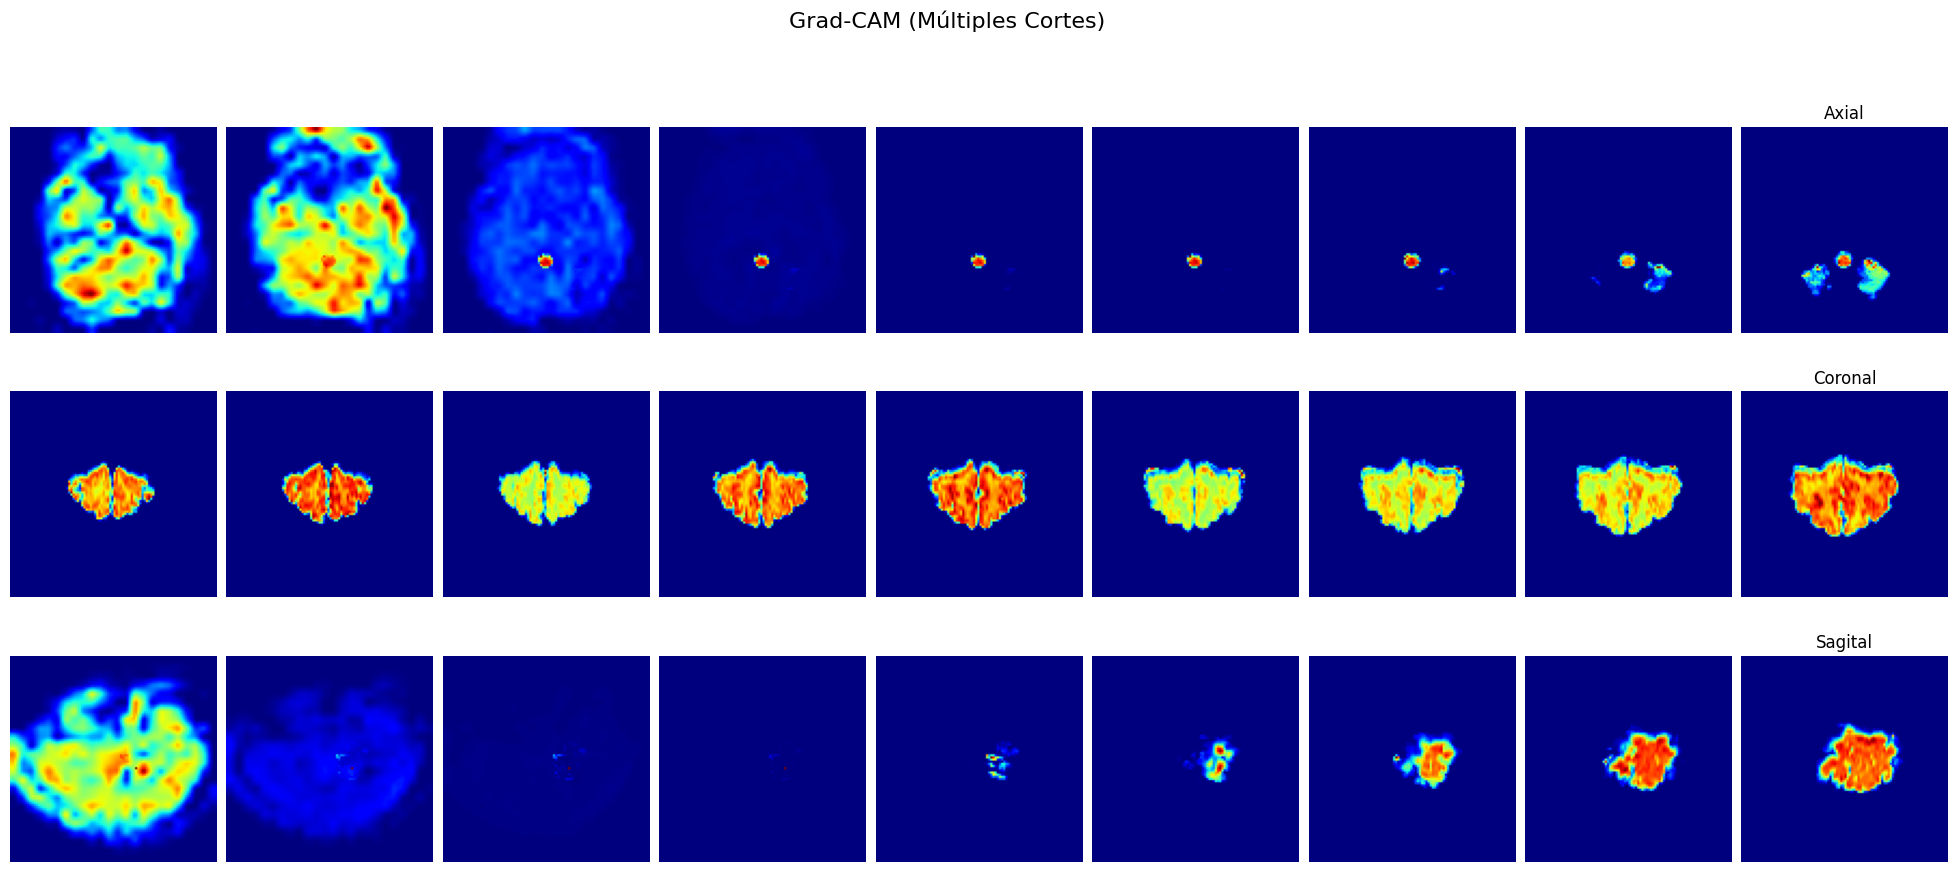

In [ ]:
# 6. VISUALIZACIÓN (Múltiples Cortes)
# Axial
center_slice = heatmap.shape[0] // 2
start_slice = max(0, center_slice - num_slices // 2)
end_slice = min(heatmap.shape[0], center_slice + (num_slices + 1) // 2)

for i, s in enumerate(range(start_slice, end_slice)):
    axial_ct_img = np.squeeze(resized_img_gradcam[s, :, :])
    axial_grad_cmap_img = np.squeeze(heatmap[s, :, :])

    axial_grad_cmap_img = resize_if_needed(axial_grad_cmap_img, axial_ct_img.shape)
    axial_overlay = overlay_images(axial_ct_img, axial_grad_cmap_img)

    axarr[0, i].imshow(axial_overlay, cmap='jet', aspect='equal')
    axarr[0, i].axis('off')
    if i == start_slice:
        axarr[0, i].set_title(f'Axial')

# Coronal
center_slice2 = heatmap.shape[1] // 2
start_slice2 = max(0, center_slice2 - num_slices // 2)
end_slice2 = min(heatmap.shape[1], center_slice2 + (num_slices + 1) // 2)

for i, s in enumerate(range(start_slice2, end_slice2)):
    coronal_ct_img = np.squeeze(resized_img_gradcam[:, s, :])
    coronal_grad_cmap_img = np.squeeze(heatmap[:, s, :])

    coronal_grad_cmap_img = resize_if_needed(coronal_grad_cmap_img, coronal_ct_img.shape)
    coronal_overlay = overlay_images(coronal_ct_img, coronal_grad_cmap_img)

    axarr[1, i].imshow(coronal_overlay, cmap='jet', aspect='equal')
    axarr[1, i].axis('off')
    if i == start_slice2:
        axarr[1, i].set_title(f'Coronal')

# Sagital
center_slice3 = heatmap.shape[2] // 2
start_slice3 = max(0, center_slice3 - num_slices // 2)
end_slice3 = min(heatmap.shape[2], center_slice3 + (num_slices + 1) // 2)

for i, s in enumerate(range(start_slice3, end_slice3)):
    sagittal_ct_img = np.squeeze(resized_img_gradcam[:, :, s])
    sagittal_grad_cmap_img = np.squeeze(heatmap[:, :, s])

    sagittal_grad_cmap_img = resize_if_needed(sagittal_grad_cmap_img, sagittal_ct_img.shape)
    sagittal_overlay = overlay_images(sagittal_ct_img, sagittal_grad_cmap_img)

    axarr[2, i].imshow(sagittal_overlay, cmap='jet', aspect='equal')
    axarr[2, i].axis('off')
    if i == start_slice3:
        axarr[2, i].set_title(f'Sagital')

plt.show()

<ipython-input-19-9c62e6b9dbf8>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

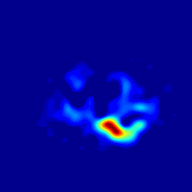

In [ ]:
# GIF animado de slices coronales
output_dir = '/content/coronal_slices_gif'
os.makedirs(output_dir, exist_ok=True)
filenames = []
scale_factor = 2.0

for i in range(resized_img_gradcam.shape[1]):
    coronal_ct_img = np.squeeze(resized_img_gradcam[:, :, i])
    coronal_grad_cmap_img = np.squeeze(heatmap[:, :, i])

    if coronal_ct_img.shape != coronal_grad_cmap_img.shape:
        coronal_grad_cmap_img = cv2.resize(coronal_grad_cmap_img, (coronal_ct_img.shape[1], coronal_ct_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    coronal_ct_img = coronal_ct_img.astype(np.float32)
    coronal_grad_cmap_img = coronal_grad_cmap_img.astype(np.float32)
    coronal_overlay = cv2.addWeighted(coronal_ct_img, 0.5, coronal_grad_cmap_img, 0.5, 0)

    height, width = coronal_overlay.shape[:2]
    resized_overlay = cv2.resize(coronal_overlay, (int(width * scale_factor), int(height * scale_factor)), interpolation=cv2.INTER_LANCZOS4)

    # Guarda la imagen combinada (overlay)
    filename = os.path.join(output_dir, f'coronal_{i:03d}.png')
    filenames.append(filename)
    plt.imsave(filename, resized_overlay, cmap='jet')

with imageio.get_writer('/content/coronal_slices.gif', mode='I', duration=0.3, loop = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

from IPython.display import Image
Image(open('/content/coronal_slices.gif','rb').read())